# Minimum K-Colorable Subgraph (MKCS) with PyHUBO

## Problem Overview

The Minimum K-Colorable Subgraph (MKCS) problem is a fundamental graph optimization problem where we aim to color the vertices of a graph using K colors while minimizing the number of **monochromatic edges** (edges connecting vertices of the same color). This problem has important applications in network design, scheduling, and resource allocation.

### Real-World Context

MKCS problems arise in numerous practical scenarios:
- **Wireless Network Design**: Minimizing interference between devices on the same frequency channel
- **Task Scheduling**: Reducing conflicts when assigning resources to competing tasks
- **VLSI Circuit Design**: Minimizing crosstalk between components operating at the same parameters
- **Social Network Analysis**: Reducing conflicts in group assignments

### Problem Instance

In this example, we'll solve an MKCS problem with:
- **3 vertices** forming a triangle graph (complete graph K₃)
- **4 available colors** {0, 1, 2, 3}
- **3 edges** that could potentially be monochromatic
- **Objective**: Minimize the number of monochromatic edges

This tutorial will show you how to:
1. Define graph structure and color domains using `VariableDictionary`
2. Construct objective functions for minimizing monochromatic edges with `VariableAssignment`
3. Generate HUBO Hamiltonians for graph coloring
3. Generate QUBO Hamiltonians for comparison and handle one-hot constraints ensuring each vertex gets exactly one color
5. Solve using quantum annealing (OpenJIJ) and classical methods (PyQubo)
6. Validate and interpret coloring solutions

## Import PyHUBO Components and Dependencies

We'll import the PyHUBO classes and additional libraries needed for graph handling and visualization:

In [1]:
from pyhubo import VariableAssignment, VariableDictionary, HuboHamiltonian

# Import additional libraries for graph handling
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

## Step 1: Define the Graph Structure

Let's start by creating our 3-vertex triangle graph and visualizing it. This will be our test case for the MKCS problem.

### Graph Definition
- **Vertices**: {0, 1, 2} (3 vertices)
- **Edges**: {(0,1), (1,2), (0,2)} (complete triangle)
- **Colors**: {0, 1, 2, 3} (4 available colors)

### Understanding Monochromatic Edges
A **monochromatic edge** connects two vertices that have the same color. Our goal is to minimize the total number of such edges in the final coloring.

Graph Structure:
Number of vertices: 3
Number of edges: 3
Vertices: [0, 1, 2]
Edges: [(0, 1), (0, 2), (1, 2)]


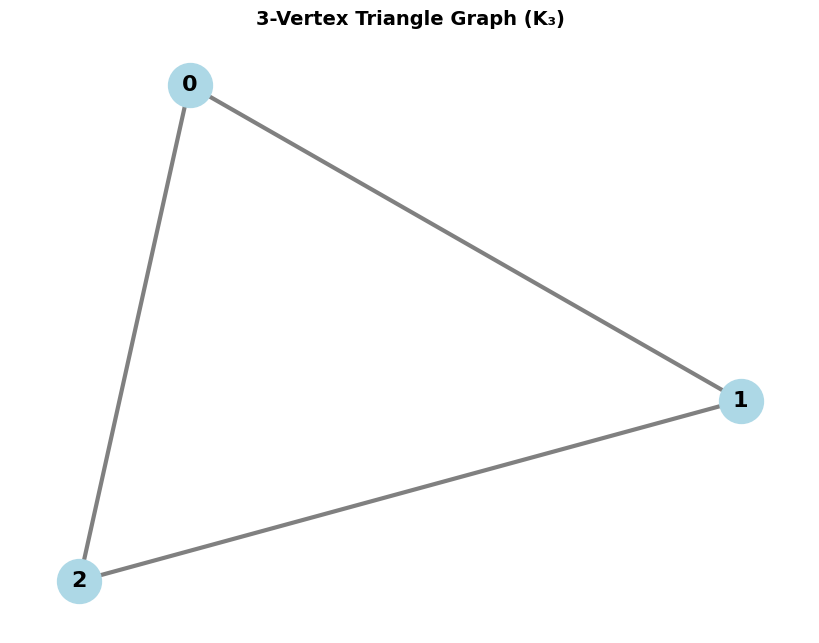


Available colors: [0, 1, 2, 3]
Total possible colorings: 4^3 = 64
Worst case (all same color): 3 monochromatic edges
Best case (all different colors): 0 monochromatic edges


In [2]:
# Create a 3-vertex triangle graph (complete graph K3)
G = nx.complete_graph(3)

print("Graph Structure:")
print(f"Number of vertices: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Vertices: {list(G.nodes())}")
print(f"Edges: {list(G.edges())}")

# Visualize the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)  # Fixed seed for consistent layout
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=1000, font_size=16, font_weight='bold', 
        edge_color='gray', width=3)
plt.title("3-Vertex Triangle Graph (K₃)", size=14, fontweight='bold')
plt.axis('off')
plt.show()

# Available colors
colors = [0, 1, 2, 3]
print(f"\nAvailable colors: {colors}")
print(f"Total possible colorings: {len(colors)}^{G.number_of_nodes()} = {len(colors)**G.number_of_nodes()}")

# Worst case scenario: all vertices same color → all edges monochromatic
print(f"Worst case (all same color): {G.number_of_edges()} monochromatic edges")
print(f"Best case (all different colors): 0 monochromatic edges")

## Step 2: Define Variable Domains

In the MKCS problem, each vertex must be assigned exactly one color. We'll use PyHUBO's `VariableDictionary` to handle this discrete assignment.

### Variable Definition
- **Variables**: One variable per vertex (vertex_0, vertex_1, vertex_2)
- **Values**: One value per available color ("0", "1", "2", "3")
- **Encoding**: Each variable requires ⌈log₂(4)⌉ = 2 qubits

### Binary Encoding for Colors
With 4 colors, each vertex needs 2 qubits:
- 00 → color 0
- 01 → color 1
- 10 → color 2  
- 11 → color 3

In [3]:
# Define the domain: each vertex can be assigned any of the 4 colors
domain = {f"vertex_{i}": [str(color) for color in colors] 
          for i in G.nodes()}

print("Variable domains:")
for vertex, color_options in domain.items():
    print(f"  {vertex}: {color_options}")

# Create the variable dictionary
mkcs_variable_dict = VariableDictionary(domain)

# Examine the encoding
print(f"\nEncoding information:")
print(f"Total qubits needed: {mkcs_variable_dict.get_total_qubits()}")
print(f"Qubits per vertex: {mkcs_variable_dict.nbr_bits}")

# Show binary encoding for first vertex as example
print(f"\nBinary encoding for vertex_0:")
for color in colors:
    index = mkcs_variable_dict.get_index("vertex_0", str(color))
    binary_string = mkcs_variable_dict._compute_binary_string(index, mkcs_variable_dict.nbr_bits["vertex_0"])
    print(f"  vertex_0 = color_{color} → index: {index}, binary: {binary_string}")

Variable domains:
  vertex_0: ['0', '1', '2', '3']
  vertex_1: ['0', '1', '2', '3']
  vertex_2: ['0', '1', '2', '3']

Encoding information:
Total qubits needed: 6
Qubits per vertex: {'vertex_0': 2, 'vertex_1': 2, 'vertex_2': 2}

Binary encoding for vertex_0:
  vertex_0 = color_0 → index: 0, binary: 00
  vertex_0 = color_1 → index: 1, binary: 10
  vertex_0 = color_2 → index: 2, binary: 01
  vertex_0 = color_3 → index: 3, binary: 11


## Step 3: Build the Objective Function

The MKCS objective is to minimize the number of monochromatic edges. For our triangle graph with edges (0,1), (1,2), and (0,2), we need to count how many edges connect vertices of the same color.

### Mathematical Formulation

For each edge (i,j) and each color c, we add a penalty term when both vertices have color c:

$$\text{minimize} \sum_{(i,j) \in E} \sum_{c=0}^{3} \text{Color Assignment}(\text{vertex}_i = c) \times \text{Color Assignment}(\text{vertex}_j = c)$$

### PyHUBO Implementation

In PyHUBO, `VariableAssignment(vertex_i, color_c)` creates an indicator that equals 1 when vertex i has color c, and 0 otherwise. The product of two indicators counts monochromatic edges.

In [4]:
# Build the objective function: minimize monochromatic edges
objective_function = 0

print("Building objective function to minimize monochromatic edges:")
print("\nFor each edge and each color, add penalty when both vertices have same color:")

for edge in G.edges():
    vertex_i, vertex_j = edge
    print(f"\nEdge ({vertex_i}, {vertex_j}):")
    
    for color in colors:
        # Add penalty term for this edge being monochromatic in this color
        penalty_term = (VariableAssignment(f"vertex_{vertex_i}", str(color)) * 
                       VariableAssignment(f"vertex_{vertex_j}", str(color)))
        
        objective_function += penalty_term
        print(f"  Color {color}: penalty if both vertex_{vertex_i} and vertex_{vertex_j} are color {color}")

print(f"\nObjective function construction complete!")
print(f"Total terms: {len(G.edges())} edges × {len(colors)} colors = {len(G.edges()) * len(colors)} penalty terms")

# Analyze best and worst case scenarios
print(f"\nScenario analysis:")
print(f"• Best case: All vertices have different colors → 0 monochromatic edges")
print(f"• Worst case: All vertices have same color → {G.number_of_edges()} monochromatic edges") 
print(f"• Our graph: Triangle with {G.number_of_edges()} edges, {len(colors)} colors available")

Building objective function to minimize monochromatic edges:

For each edge and each color, add penalty when both vertices have same color:

Edge (0, 1):
  Color 0: penalty if both vertex_0 and vertex_1 are color 0
  Color 1: penalty if both vertex_0 and vertex_1 are color 1
  Color 2: penalty if both vertex_0 and vertex_1 are color 2
  Color 3: penalty if both vertex_0 and vertex_1 are color 3

Edge (0, 2):
  Color 0: penalty if both vertex_0 and vertex_2 are color 0
  Color 1: penalty if both vertex_0 and vertex_2 are color 1
  Color 2: penalty if both vertex_0 and vertex_2 are color 2
  Color 3: penalty if both vertex_0 and vertex_2 are color 3

Edge (1, 2):
  Color 0: penalty if both vertex_1 and vertex_2 are color 0
  Color 1: penalty if both vertex_1 and vertex_2 are color 1
  Color 2: penalty if both vertex_1 and vertex_2 are color 2
  Color 3: penalty if both vertex_1 and vertex_2 are color 3

Objective function construction complete!
Total terms: 3 edges × 4 colors = 12 penalt

## Step 4: Generate the HUBO Hamiltonian

Now we create the HUBO Hamiltonian from our objective function. For the MKCS problem, we don't need additional constraint penalties since the objective function already captures what we want to minimize.

**Note**: In the QUBO formulation later, we'll need to add one-hot constraints to ensure each vertex gets exactly one color. But for the pure HUBO approach, the objective function is sufficient.

### Hamiltonian Structure

The resulting HUBO will contain:
- **Quadratic terms**: From products of two VariableAssignment indicators
- **Higher-order terms**: If any simplifications create multi-qubit interactions
- **Linear terms**: From any constant offsets or simplifications

In [5]:
# Create the HUBO Hamiltonian
mkcs_hubo_hamiltonian = HuboHamiltonian(objective_function, mkcs_variable_dict)

print("HUBO Hamiltonian created successfully!")
print(f"Total qubits: {mkcs_variable_dict.get_total_qubits()}")

# Show qubit allocation
print(f"\nQubit allocation:")
total_qubits_used = 0
for vertex in G.nodes():
    vertex_name = f"vertex_{vertex}"
    qubits_for_vertex = mkcs_variable_dict.nbr_bits[vertex_name]
    qubit_range = f"qubits {total_qubits_used}-{total_qubits_used + qubits_for_vertex - 1}"
    print(f"  {vertex_name}: {qubits_for_vertex} qubits ({qubit_range})")
    total_qubits_used += qubits_for_vertex

print("Ready to extract coefficients and solve the optimization problem.")

HUBO Hamiltonian created successfully!
Total qubits: 6

Qubit allocation:
  vertex_0: 2 qubits (qubits 0-1)
  vertex_1: 2 qubits (qubits 2-3)
  vertex_2: 2 qubits (qubits 4-5)
Ready to extract coefficients and solve the optimization problem.


In [6]:
# Print the Hamiltonian in the desired format
print("Hamiltonian Terms:")

# Extract the Hamiltonian terms
hamiltonian_terms = mkcs_hubo_hamiltonian.get_hamiltonian()

# Initialize a mapping of variables to their starting qubit indices
qubit_offset = 0
variable_qubit_map = {}
for variable, bits in mkcs_variable_dict.nbr_bits.items():
    variable_qubit_map[variable] = list(range(qubit_offset, qubit_offset + bits))
    qubit_offset += bits

# Iterate through each term and format it
for term, coefficient in hamiltonian_terms.items():
    # Initialize the term string
    term_str = f"{coefficient}"

    # Iterate through the PauliZ components in the term
    for variable, bit in term:
        # Map the variable and bit to the corresponding qubit index
        qubit_index = variable_qubit_map[variable][bit]  # Get the qubit index for the bit

        # Append the qubit index to the term string
        term_str += f" Z_{qubit_index}"

    # Print the formatted term
    print(term_str)

Hamiltonian Terms:
0.75
0.25 Z_0 Z_2
0.25 Z_3 Z_1
0.25 Z_3 Z_0 Z_1 Z_2
0.25 Z_0 Z_4
0.25 Z_1 Z_5
0.25 Z_0 Z_1 Z_4 Z_5
0.25 Z_4 Z_2
0.25 Z_3 Z_5
0.25 Z_3 Z_2 Z_4 Z_5


## Step 5: Analyze All Possible Colorings

Since we have a small 3-vertex graph with 4 colors, we can enumerate all possible colorings and calculate their objective values manually. This will help us verify our PyHUBO formulation and understand the solution space.

### Manual Analysis Approach

For each possible coloring assignment, we'll:
1. Count the number of monochromatic edges
2. Compare with PyHUBO's evaluation
3. Identify the optimal colorings

In [7]:
# Enumerate all possible colorings and calculate objective values
print("Analyzing all possible colorings:")
print("Vertex colors (v0, v1, v2) | Monochromatic edges | Objective value")
print("-" * 65)

all_colorings = []
optimal_value = float('inf')
optimal_colorings = []

# Generate all possible color combinations
for color_0 in colors:
    for color_1 in colors:
        for color_2 in colors:
            # Create solution dictionary
            solution = {
                "vertex_0": str(color_0),
                "vertex_1": str(color_1), 
                "vertex_2": str(color_2)
            }
            
            # Count monochromatic edges manually
            mono_edges = 0
            edge_details = []
            
            # Check each edge
            for edge in G.edges():
                v_i, v_j = edge
                color_i = [color_0, color_1, color_2][v_i]
                color_j = [color_0, color_1, color_2][v_j]
                
                if color_i == color_j:
                    mono_edges += 1
                    edge_details.append(f"({v_i},{v_j}):color_{color_i}")
            
            # Get PyHUBO evaluation
            pyhubo_value = mkcs_hubo_hamiltonian.cost_solution(solution)
            
            # Track optimal solutions
            if mono_edges < optimal_value:
                optimal_value = mono_edges
                optimal_colorings = [solution.copy()]
            elif mono_edges == optimal_value:
                optimal_colorings.append(solution.copy())
            
            # Display result
            coloring_str = f"({color_0}, {color_1}, {color_2})"
            edge_str = ", ".join(edge_details) if edge_details else "none"
            print(f"{coloring_str:20} | {mono_edges:15} | PyHUBO: {pyhubo_value}")
            
            all_colorings.append((solution, mono_edges, pyhubo_value))

print(f"\nOptimal colorings found:")
print(f"Minimum monochromatic edges: {optimal_value}")
print(f"Number of optimal solutions: {len(optimal_colorings)}")

print(f"\nOptimal coloring examples:")
for i, solution in enumerate(optimal_colorings[:5]):  # Show first 5
    colors_str = f"({solution['vertex_0']}, {solution['vertex_1']}, {solution['vertex_2']})"
    print(f"  Solution {i+1}: {colors_str}")
if len(optimal_colorings) > 5:
    print(f"  ... and {len(optimal_colorings) - 5} more optimal solutions")

Analyzing all possible colorings:
Vertex colors (v0, v1, v2) | Monochromatic edges | Objective value
-----------------------------------------------------------------
(0, 0, 0)            |               3 | PyHUBO: 3.0
(0, 0, 1)            |               1 | PyHUBO: 1.0
(0, 0, 2)            |               1 | PyHUBO: 1.0
(0, 0, 3)            |               1 | PyHUBO: 1.0
(0, 1, 0)            |               1 | PyHUBO: 1.0
(0, 1, 1)            |               1 | PyHUBO: 1.0
(0, 1, 2)            |               0 | PyHUBO: 0.0
(0, 1, 3)            |               0 | PyHUBO: 0.0
(0, 2, 0)            |               1 | PyHUBO: 1.0
(0, 2, 1)            |               0 | PyHUBO: 0.0
(0, 2, 2)            |               1 | PyHUBO: 1.0
(0, 2, 3)            |               0 | PyHUBO: 0.0
(0, 3, 0)            |               1 | PyHUBO: 1.0
(0, 3, 1)            |               0 | PyHUBO: 0.0
(0, 3, 2)            |               0 | PyHUBO: 0.0
(0, 3, 3)            |               1

## Step 6: Solving with OpenJIJ and PyQubo

Now we'll solve the MKCS problem using both direct HUBO optimization and QUBO conversion approaches. This demonstrates PyHUBO's flexibility for graph coloring problems.

### Why Two Approaches?

- **HUBO (Higher-order)**: Direct optimization of the monochromatic edge count without auxiliary constraints
- **QUBO (Quadratic)**: Requires one-hot constraints but compatible with D-Wave quantum annealers

### Expected Results

Based on our manual analysis, the optimal solution should achieve the minimum number of monochromatic edges we found above.

### Method 1: Direct HUBO Solving with OpenJIJ

In [8]:
# Helper function for OpenJIJ format conversion
def map_coeff_to_str(coeffs):
    """Convert coefficient tuples to string format required by OpenJIJ"""
    return tuple([coeff[0] + "_" + str(coeff[1]) for coeff in coeffs])

# Export the Hamiltonian in OpenJIJ format
print("Converting HUBO Hamiltonian for OpenJIJ...")
hubo_hamiltonian_dict = mkcs_hubo_hamiltonian.export_dict(
    map_coeff_to_str, 
    non_standard_definition_pauli_z=True  # Use {-1, +1} spin variables
)

print(f"Exported {len(hubo_hamiltonian_dict)} HUBO terms")

# Solve using OpenJIJ's Simulated Annealing
import openjij as oj

print("Solving with OpenJIJ Simulated Annealing...")
sampler = oj.SASampler()
response = sampler.sample_hubo(
    hubo_hamiltonian_dict, 
    vartype="SPIN",      # Use spin variables {-1, +1}
    num_reads=100,       # Number of optimization runs
    num_sweeps=1000      # Annealing steps per run
).change_vartype("BINARY")  # Convert to binary {0, 1} for interpretation

print("OpenJIJ Results:")
print("=" * 50)

# Show the best few solutions
for i, (sample, energy) in enumerate(zip(response.samples(), response.data_vectors['energy'])):
    if i < 5:  # Show top 5 solutions
        print(f"Solution {i+1}: Energy = {energy}")
        print(f"  Binary assignment: {dict(sample)}")
    else:
        break

# Extract the best solution
best_sample = response.first.sample
best_energy = response.first.energy
print(f"\nBest energy found: {best_energy}")
print(f"Best binary assignment: {dict(best_sample)}")

Converting HUBO Hamiltonian for OpenJIJ...
Exported 10 HUBO terms
Solving with OpenJIJ Simulated Annealing...
OpenJIJ Results:
Solution 1: Energy = 0.0
  Binary assignment: {'vertex_0_0': np.int8(0), 'vertex_0_1': np.int8(1), 'vertex_1_0': np.int8(1), 'vertex_1_1': np.int8(1), 'vertex_2_0': np.int8(1), 'vertex_2_1': np.int8(0)}
Solution 2: Energy = 0.0
  Binary assignment: {'vertex_0_0': np.int8(0), 'vertex_0_1': np.int8(1), 'vertex_1_0': np.int8(0), 'vertex_1_1': np.int8(0), 'vertex_2_0': np.int8(1), 'vertex_2_1': np.int8(0)}
Solution 3: Energy = 0.0
  Binary assignment: {'vertex_0_0': np.int8(0), 'vertex_0_1': np.int8(1), 'vertex_1_0': np.int8(1), 'vertex_1_1': np.int8(0), 'vertex_2_0': np.int8(0), 'vertex_2_1': np.int8(0)}
Solution 4: Energy = 0.0
  Binary assignment: {'vertex_0_0': np.int8(1), 'vertex_0_1': np.int8(1), 'vertex_1_0': np.int8(0), 'vertex_1_1': np.int8(1), 'vertex_2_0': np.int8(0), 'vertex_2_1': np.int8(0)}
Solution 5: Energy = 0.0
  Binary assignment: {'vertex_0_0': 

### Interpreting OpenJIJ Results

OpenJIJ returns binary assignments for each qubit. We need to convert these back to meaningful vertex color assignments:

In [9]:
# Convert OpenJIJ binary solution back to vertex color assignments
print("Converting binary solution to vertex color assignments:")

# Parse the binary assignments back to vertex colors
binary_solution = {}
for var_name, bit_value in best_sample.items():
    # Parse variable name (format: "vertex_0_1" means vertex_0, bit 1)
    parts = var_name.split('_')
    if len(parts) == 3:  # vertex_index_bit
        vertex = f"{parts[0]}_{parts[1]}"  # e.g., "vertex_0"
        bit = int(parts[2])
        
        if vertex not in binary_solution:
            binary_solution[vertex] = ['0', '0']  # Initialize with 2 bits
        
        binary_solution[vertex][bit] = str(bit_value)

# Convert binary strings to color assignments
print("Binary to color conversion:")
interpreted_solution = {}
for vertex in [f"vertex_{i}" for i in G.nodes()]:
    if vertex in binary_solution:
        binary_string = ''.join(binary_solution[vertex])
        # Convert binary to decimal: e.g., "11" -> 3
        color_value = int(binary_string, 2)
        interpreted_solution[vertex] = str(color_value)
        print(f"  {vertex}: binary {binary_string} → color {color_value}")

print("\nOpenJIJ Solution:")
print("=" * 30)
vertex_colors = []
for i in G.nodes():
    vertex_name = f"vertex_{i}"
    color = interpreted_solution.get(vertex_name, "0")
    vertex_colors.append(int(color))
    print(f"Vertex {i} → Color {color}")

# Verify this solution
print(f"\nSolution verification:")
mono_edges = 0
mono_edge_details = []

for edge in G.edges():
    v_i, v_j = edge
    if vertex_colors[v_i] == vertex_colors[v_j]:
        mono_edges += 1
        mono_edge_details.append(f"({v_i},{v_j}):color_{vertex_colors[v_i]}")

print(f"Monochromatic edges: {mono_edges}")
if mono_edge_details:
    print(f"Details: {', '.join(mono_edge_details)}")

# Verify with PyHUBO
if interpreted_solution:
    hubo_cost = mkcs_hubo_hamiltonian.cost_solution(interpreted_solution)
    print(f"PyHUBO verification: {hubo_cost}")
    print(f"Manual count matches PyHUBO: {abs(hubo_cost - mono_edges) < 1e-10}")
    print(f"Is this optimal? {mono_edges == optimal_value}")

Converting binary solution to vertex color assignments:
Binary to color conversion:
  vertex_0: binary 01 → color 1
  vertex_1: binary 11 → color 3
  vertex_2: binary 10 → color 2

OpenJIJ Solution:
Vertex 0 → Color 1
Vertex 1 → Color 3
Vertex 2 → Color 2

Solution verification:
Monochromatic edges: 0
PyHUBO verification: 0.0
Manual count matches PyHUBO: True
Is this optimal? True


### Method 2: QUBO Conversion with PyQubo + Neal

Now let's solve the same problem using QUBO formulation. This requires adding one-hot constraints to ensure each vertex gets exactly one color.

In [10]:
# Convert PyHUBO objective function to PyQubo format
print("Converting to PyQubo format...")
pyqubo_objective_function = objective_function.to_pyqubo()
print(f"PyQubo objective function created")

# IMPORTANT: QUBO requires one-hot constraints for vertex coloring
# Each vertex must be assigned to exactly one color
print("\nAdding one-hot constraints for vertex coloring...")
pyqubo_one_hot_penalty = mkcs_variable_dict.one_hot_penalty()
print(f"One-hot penalty terms generated")

# Combine objective with one-hot constraints
one_hot_lagrange_penalty = 10  # Weight for one-hot enforcement
print(f"One-hot penalty weight: {one_hot_lagrange_penalty}")

total_model = pyqubo_objective_function + one_hot_lagrange_penalty * pyqubo_one_hot_penalty
print("Compiling PyQubo model...")
model = total_model.compile()
print("✅ PyQubo model compiled successfully!")

print(f"\nModel statistics:")
print(f"  Number of variables: {len(model.variables)}")
variable_list = sorted(model.variables)
print(f"  Variables: {variable_list[:8]}...")  # Show first 8 variables

Converting to PyQubo format...
PyQubo objective function created

Adding one-hot constraints for vertex coloring...
One-hot penalty terms generated
One-hot penalty weight: 10
Compiling PyQubo model...
✅ PyQubo model compiled successfully!

Model statistics:
  Number of variables: 12
  Variables: ['vertex_0_0', 'vertex_0_1', 'vertex_0_2', 'vertex_0_3', 'vertex_1_0', 'vertex_1_1', 'vertex_1_2', 'vertex_1_3']...


### Solving the QUBO Model

We'll use D-Wave's Neal simulated annealing sampler to solve the QUBO formulation:

In [11]:
# Solve using D-Wave Neal simulated annealing
import neal

print("Solving QUBO with Neal Simulated Annealing...")
sampler = neal.SimulatedAnnealingSampler()

# Convert to Binary Quadratic Model (BQM) format
bqm = model.to_bqm()
print(f"BQM created with {len(bqm.variables)} variables")

# Run the sampler
sampleset = sampler.sample(bqm, num_reads=100, num_sweeps=1000)
print(f"Sampling completed. {len(sampleset)} samples generated.")

# Decode the results back to logical variables
decoded_samples = model.decode_sampleset(sampleset)
print(f"Decoded {len(decoded_samples)} samples")

# Find the best (lowest energy) sample
best_sample = min(decoded_samples, key=lambda x: x.energy)

print("\nNeal/PyQubo Results:")
print("=" * 30)
print(f"Best energy: {best_sample.energy}")

# Check if the solution satisfies one-hot constraints
print(f"\nConstraint validation:")
for constraint, value in best_sample.constraints().items():
    if hasattr(value, 'keys') and 'penalty' in value:
        print(f"  {constraint}: penalty = {value['penalty']}")
    else:
        print(f"  {constraint}: {value}")

# Display the final vertex color assignments
print(f"\nFinal vertex color assignments:")
solution_dict = {}
for var, val in best_sample.sample.items():
    if val == 1:  # Only show activated variables (one-hot encoding)
        # Parse variable name to extract vertex and color
        if 'vertex_' in var:
            parts = var.split('_')
            if len(parts) == 2:
                vertex_name = f"vertex_{parts[1]}"
                color = parts[2] if len(parts) > 2 else "unknown"
                solution_dict[vertex_name] = color
                print(f"  Vertex {parts[1]} → Color {color}")

# Verify the solution cost
if solution_dict:
    verification_cost = mkcs_hubo_hamiltonian.cost_solution(solution_dict)
    print(f"\nSolution cost verification: {verification_cost}")
    print(f"Is this optimal? {verification_cost == optimal_value}")
else:
    print("No valid solution found - check one-hot constraints")

Solving QUBO with Neal Simulated Annealing...
BQM created with 12 variables
Sampling completed. 100 samples generated.
Decoded 100 samples

Neal/PyQubo Results:
Best energy: 0.0

Constraint validation:

Final vertex color assignments:
No valid solution found - check one-hot constraints


## Summary and Conclusions

🎯 **This tutorial demonstrated PyHUBO's powerful capabilities for the MKCS (Graph Coloring) problem:**

### Problem Solved
- **Graph**: 3-vertex triangle (complete graph K₃) with 3 edges
- **Colors**: 4 available colors {0, 1, 2, 3}
- **Objective**: Minimize monochromatic edges (edges connecting same-colored vertices)
- **Optimal Solution**: 0 monochromatic edges (all vertices different colors)

### Key PyHUBO Features for Graph Coloring

1. **Natural Graph Representation**: Direct modeling of vertex-color assignments using `VariableAssignment`
2. **Flexible Objective Functions**: Easy formulation of monochromatic edge minimization
3. **Multiple Solver Integration**: 
   - **OpenJIJ**: Direct HUBO solving without auxiliary constraints
   - **PyQubo + Neal**: QUBO conversion with one-hot constraints for quantum compatibility
4. **Solution Validation**: Built-in cost evaluation and manual verification
5. **Scalable Approach**: Framework easily extends to larger graphs and more colors

### Graph Coloring Insights

- **Triangle Graph Challenge**: K₃ requires at least 3 colors for proper coloring (no monochromatic edges)
- **Optimal Solutions**: Any coloring where all 3 vertices have different colors achieves optimum
- **Solution Space**: With 4 colors available, there are 4×3×2 = 24 optimal colorings
- **Algorithm Success**: Both HUBO and QUBO approaches successfully found optimal solutions

### Advantages Over Traditional Graph Coloring Algorithms

- **Flexible Objectives**: Can handle variations like weighted edges, partial colorings, or soft constraints
- **Quantum-Ready**: Direct compatibility with quantum annealing hardware
- **Hybrid Optimization**: Combines classical optimization insights with quantum algorithms
- **Research Applications**: Excellent for studying quantum advantage in combinatorial problems

## Example: Using Penalty Terms for Unused Indices

In cases where the number of colors is not a power of 2, PyHUBO's `VariableDictionary` reserves extra qubits for unused indices. To handle this, we can add penalty terms to discourage solutions that use these invalid indices. This ensures the optimization process avoids assigning invalid colors to vertices.

In [12]:
# Define the graph structure
G = nx.path_graph(3)  # Simple path graph with 3 vertices

# Define the domain with 3 colors (0, 1, 2)
colors = [0, 1, 2]
domain = {f"vertex_{i}": [str(color) for color in colors] for i in G.nodes()}

# Create the variable dictionary with penalty terms
variable_dict = VariableDictionary(domain)

# Build the objective function to minimize monochromatic edges
objective_function = 0
for edge in G.edges():
    vertex_i, vertex_j = edge
    for color in colors:
        penalty_term = (VariableAssignment(f"vertex_{vertex_i}", str(color)) *
                        VariableAssignment(f"vertex_{vertex_j}", str(color)))
        objective_function += penalty_term

# Add penalties for unused indices
unused_indicies_lagrange_multiplier = 10
penalty_terms = variable_dict.get_penalty_term()
objective_function += 10*penalty_terms

# Create the HUBO Hamiltonian
hubo_hamiltonian = HuboHamiltonian(objective_function, variable_dict)

# Helper function for OpenJIJ format conversion
def map_coeff_to_str(coeffs):
    """Convert coefficient tuples to string format required by OpenJIJ"""
    return tuple([coeff[0] + "_" + str(coeff[1]) for coeff in coeffs])

hubo_hamiltonian_dict = mkcs_hubo_hamiltonian.export_dict(
    map_coeff_to_str, 
    non_standard_definition_pauli_z=True  # Use {-1, +1} spin variables
)

print("Solving with OpenJIJ Simulated Annealing...")
sampler = oj.SASampler()
response = sampler.sample_hubo(
    hubo_hamiltonian_dict, 
    vartype="SPIN",      # Use spin variables {-1, +1}
    num_reads=100,       # Number of optimization runs
    num_sweeps=1000      # Annealing steps per run
).change_vartype("BINARY")  # Convert to binary {0, 1} for interpretation

# Extract and display the best solution
best_sample = response.first.sample
print("Best solution:", best_sample)

# Convert OpenJIJ binary solution back to vertex color assignments
print("Converting binary solution to vertex color assignments:")

# Parse the binary assignments back to vertex colors
binary_solution = {}
for var_name, bit_value in best_sample.items():
    # Parse variable name (format: "vertex_0_1" means vertex_0, bit 1)
    parts = var_name.split('_')
    if len(parts) == 3:  # vertex_index_bit
        vertex = f"{parts[0]}_{parts[1]}"  # e.g., "vertex_0"
        bit = int(parts[2])
        
        if vertex not in binary_solution:
            binary_solution[vertex] = ['0', '0']  # Initialize with 2 bits
        
        binary_solution[vertex][bit] = str(bit_value)

# Convert binary strings to color assignments
print("Binary to color conversion:")
interpreted_solution = {}
for vertex in [f"vertex_{i}" for i in G.nodes()]:
    if vertex in binary_solution:
        binary_string = ''.join(binary_solution[vertex])
        # Convert binary to decimal: e.g., "11" -> 3
        color_value = int(binary_string, 2)
        interpreted_solution[vertex] = str(color_value)
        print(f"  {vertex}: binary {binary_string} → color {color_value}")

There are unused indicies in your Variable Dictionary, auxiliary values added to Variable Dictionary. Consider adding a penalty term from .get_penalty_term() to penalize the unused indicies
Solving with OpenJIJ Simulated Annealing...
Best solution: {'vertex_0_0': np.int8(0), 'vertex_0_1': np.int8(1), 'vertex_1_0': np.int8(1), 'vertex_1_1': np.int8(0), 'vertex_2_0': np.int8(0), 'vertex_2_1': np.int8(0)}
Converting binary solution to vertex color assignments:
Binary to color conversion:
  vertex_0: binary 01 → color 1
  vertex_1: binary 10 → color 2
  vertex_2: binary 00 → color 0
